In [1]:
# !pip install cuda-python

In [2]:
# !pip install cupy-cuda115

In [1]:
import cupy as cp
from cupyx.scipy.signal import convolve2d as cp_convolve2d
from mpi4py import MPI
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from skimage.transform import resize
from scipy.signal import convolve2d

## [High performance with <u><i><strong>CUDA</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u> is an open-source matrix library accelerated with <u><i><strong>NVIDIA CUDA</strong></i></u>. <u><i><strong>CuPy</strong></i></u> provides GPU accelerated computing with Python. CuPy uses CUDA-related libraries including <u><i><strong>cuBLAS</strong></i></u>, <u><i><strong>cuDNN</strong></i></u>, <u><i><strong>cuRand</strong></i></u>, <u><i><strong>cuSolver</strong></i></u>, <u><i><strong>cuSPARSE</strong></i></u>, <u><i><strong>cuFFT</strong></i></u> and <u><i><strong>NCCL</strong></i></u> to make full use of the <u><i><strong>GPU</strong></i></u> architecture.
The figure shows <u><i><strong>CuPy</strong></i></u> speedup over NumPy. Most of them perform well on a <u><i><strong>GPU</strong></i></u> using CuPy out of the box. <u><i><strong>CuPy</strong></i></u> speeds up some operations more than 100X. You can read original benchmark article in [Single-<u><i><strong>GPU</strong></i></u> <u><i><strong>CuPy</strong></i></u> Speedups (RAPIDS AI)](https://medium.com/rapids-ai/single-gpu-cupy-speedups-ea99cbbb0cbb).

![CuPy speedup over NumPy](CuPy_Performance.png)

## [Highly compatible with <u><i><strong>NumPy</strong></i></u>](https://cupy.chainer.org/)
<u><i><strong>CuPy</strong></i></u>'s interface is highly compatible with <u><i><strong>NumPy</strong></i></u>; in most cases it can be used as a <strong><i><u>drop-in replacement</u></i></strong>. <i><u>All you need to do</u></i> is just <strong><i><u>replace numpy with cupy</u></i></strong> in your Python code. [Basics of <u><i><strong>CuPy</strong></i></u> (Tutorial)](https://docs-cupy.chainer.org/en/stable/tutorial/basic.html) is usefull to learn first step of <u><i><strong>CuPy</strong></i></u>.
<u><i><strong>CuPy</strong></i></u> supports various methods, indexing, data types, broadcasting and more. [Comparison Table (Reference Manual)](https://docs-cupy.chainer.org/en/stable/reference/comparison.html) shows a list of NumPy / <u><i><strong>SciPy</strong></i></u> APIs and its corresponding <u><i><strong>CuPy</strong></i></u> implementations.

In [6]:
x = cp.arange(6).reshape(2, 3).astype('f')
print("x =\n", x)

sum_result = x.sum(axis=1)
print("\nsum = ",sum_result)

x =
 [[0. 1. 2.]
 [3. 4. 5.]]

sum =  [ 3. 12.]


## [Easy to write a custom kernel](https://cupy.chainer.org/)
You can easily make a custom <u><i><strong>CUDA</strong></i></u> kernel if you want to make your code run faster, requiring only a small code snippet of <u><i><strong>C++</strong></i></u>. <u><i><strong>CuPy</strong></i></u> automatically wraps and compiles it to make a <u><i><strong>CUDA</strong></i></u> binary. Compiled binaries are cached and reused in subsequent runs. Please read [User-Defined Kernels (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html).
And, you can also use raw <u><i><strong>CUDA</strong></i></u> kernel via [Raw modules (Tutorial)](https://docs-cupy.chainer.org/en/latest/tutorial/kernel.html#raw-modules).


In [7]:
x=cp.arange(6, dtype='f').reshape(2, 3)
y=cp.arange(3, dtype='f')
kernel=cp.ElementwiseKernel(
    'float32 x,float32 y','float32 z',
        '''if(x-2>y){
        z=x*y;
        }else{
        z=x+y;
        }''',
    'my_kernel')

print("Input x = \n", x)
print("\nInput y = \n", y)

result = kernel(x, y)

print("\nresult of the kernel =\n", result)

Input x = 
 [[0. 1. 2.]
 [3. 4. 5.]]

Input y = 
 [0. 1. 2.]

result of the kernel =
 [[ 0.  2.  4.]
 [ 0.  4. 10.]]


## Task 10. Saxpy

By using <u><i><strong>CuPy</strong></i></u>, implement SAXPY function. The function is described in the picture.

![saxpy](saxpy.jpg)

CuPy is numpy accelerated with GPU (uses GPU and works faster). CuPy makes computations on GPU but in case we need to use the result on CPU or to print result somehow then it transfers (copies) data to CPU (user may not notice) and it may take time.

In [4]:
SAXPY=cp.ElementwiseKernel(
    'int32 a,float32 x,float32 y','float32 z',
        '''z=a*x+y;''',
    'my_kernel')

In [5]:
x=cp.arange(3, dtype='f')
y=cp.arange(3, dtype='f')
a=cp.random.randint(0, 4)
print("Input x = \n", x)
print("\nInput y = \n", y)

result = SAXPY(a,x,y)

print("\nresult of the kernel =\n", result)

Input x = 
 [0. 1. 2.]

Input y = 
 [0. 1. 2.]

result of the kernel =
 [0. 2. 4.]


In [6]:
a*x + y

array([0., 2., 4.])

In [7]:
cpu_times = []
gpu_times = []
for n in 2**np.arange(26):
    x=cp.arange(n, dtype='f')
    y=cp.arange(n, dtype='f')
    a=cp.random.randint(0, 4)
    time = %timeit -q -o -n 1 -r 1 a*x + y
    cpu_times.append(time.best)
    time = %timeit -q -o -n 1 -r 1 SAXPY(a,x,y)
    gpu_times.append(time.best)

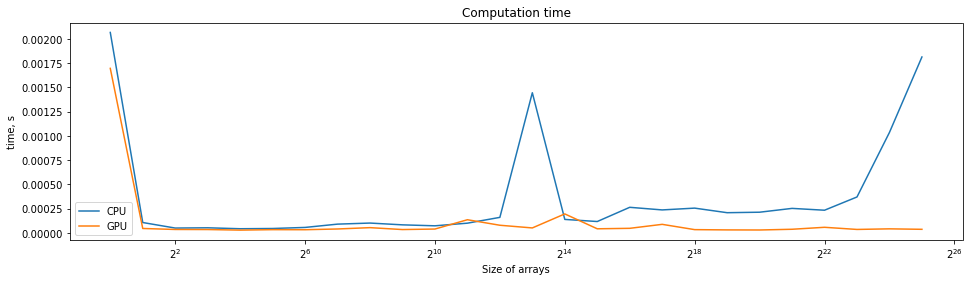

In [8]:
plt.figure(figsize=(16,4))
plt.title('Computation time')
plt.plot(2**np.arange(26), cpu_times, label='CPU')
plt.plot(2**np.arange(26), gpu_times, label='GPU')
plt.xlabel('Size of arrays')
plt.ylabel('time, s')
plt.xscale('log', base=2)
plt.legend()

## Task 11. CuPy-based Bifurcation map

By using <u><i><strong>CuPy</strong></i></u>, reimplement bifurcation map (Task 1).

### CPU

In [23]:
n = 1000
last = 100
x0 = 0.2
r = np.linspace(0, 4, 10000)
R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

for i in np.arange(1, 1000):
    x = r * X[i-1] * (1 - X[i-1])
    X[i] = x

<AxesSubplot:title={'center':'Bifurcation diagram'}>

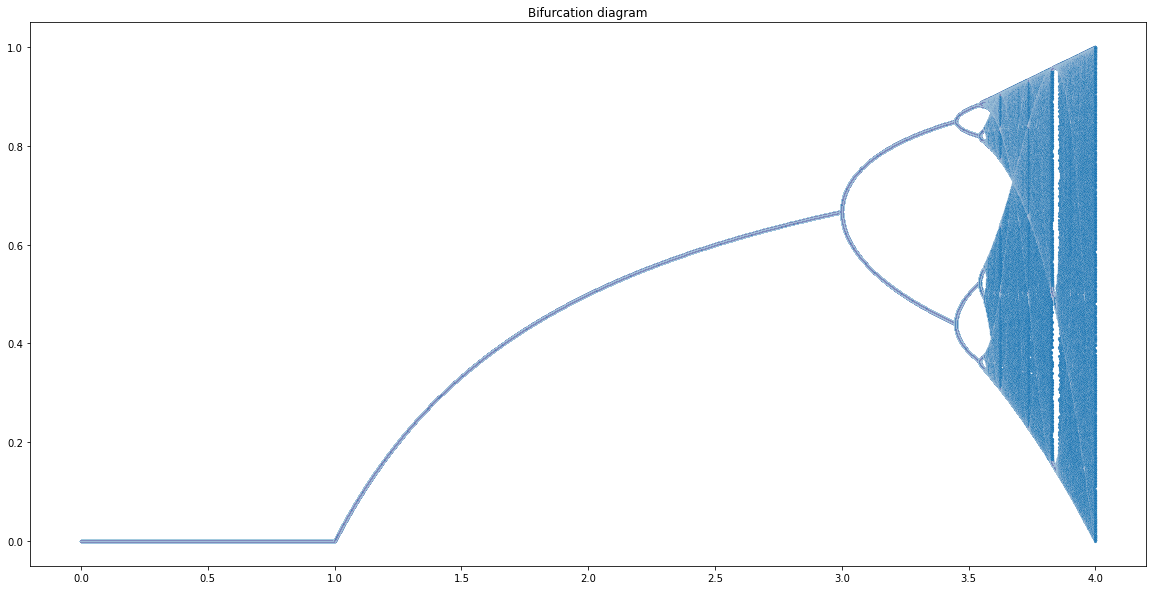

In [24]:
plt.figure(figsize=(20, 10))
plt.title('Bifurcation diagram')
sns.scatterplot(x=R, y=X[-100:].T.flatten(), s=10, linewidth=0.07)

In [25]:
def bifurcation(r, X, last):
    for i in np.arange(1, 1000):
        x = r * X[i-1] * (1 - X[i-1])
        X[i] = x
    return X[-last:].flatten()

In [26]:
n = 1000
last = 100
x0 = 0.2
r = np.linspace(0, 4, 10000)
R = (np.ones((last, len(r))) * r).T.reshape(-1)
xs = np.ones(len(r)) * x0
X = np.empty((n, len(r)))
X[0] = r * xs * (1 - xs)

In [ ]:
for n in range()

### MPI

In [ ]:
%%writefile test.py
from mpi4py import MPI
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

def LastXs(x0=0.2, r=2.0, n=1000, last=100):
    x = [x0]
    for i in range(n-1):
        x += [r * x[i] * (1 - x[i])]
    return x[-last:]

n = 1000
rs = []
xs = []
last = 100

start =  MPI.Wtime()

comm = MPI.COMM_WORLD
size=comm.Get_size()
rank=comm.Get_rank()

for r in np.linspace(4*rank/size, 4*(rank+1)/size, int(10000//size)):
    xs += LastXs(r=r, n=n, last=last)
    rs += [r]*last

xs = np.array(comm.gather(xs, root=0))
rs = np.array(comm.gather(rs, root=0))

end = MPI.Wtime()

if rank==0: 
    print(end-start)

### CuPy

In [27]:
next_x=cp.ElementwiseKernel(
    'float64 r, float64 x','float64 z',
        '''z=r*x*(1-x);''',
    'next_x')

In [28]:
r = cp.linspace(0, 4, 10000)
xs = cp.ones(len(r)) * x0
next_x(r, xs)

array([0.00000000e+00, 6.40064006e-05, 1.28012801e-04, ...,
       6.39871987e-01, 6.39935994e-01, 6.40000000e-01])

In [29]:
n = 1000
last = 100
x0 = 0.2
r = cp.linspace(0, 4, 10000)
R = (cp.ones((last, len(r))) * r).T.reshape(-1)
xs = cp.ones(len(r)) * x0
X = cp.empty((n, len(r)))
X[0] = next_x(r, xs)

for i in cp.arange(1, 1000):
    x = next_x(r, X[i-1])
    X[i] = x

<AxesSubplot:title={'center':'Bifurcation diagram'}>

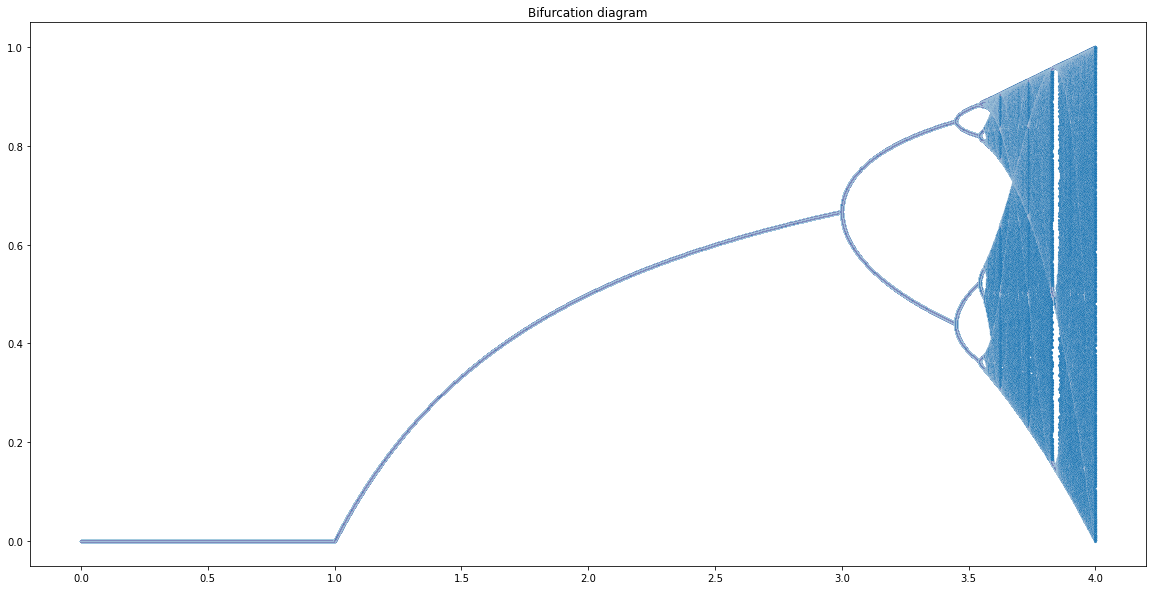

In [30]:
plt.figure(figsize=(20, 10))
plt.title('Bifurcation diagram')
sns.scatterplot(x=R.get(), y=X[-100:].T.flatten().get(), s=10, linewidth=0.07)

In [31]:
%load_ext snakeviz

In [32]:
%%snakeviz
n = 1000
last = 100
x0 = 0.2
r = cp.linspace(0, 4, 10000)
R = (cp.ones((last, len(r))) * r).T.reshape(-1)
xs = cp.ones(len(r)) * x0
X = cp.empty((n, len(r)))
X[0] = next_x(r, xs)

for i in cp.arange(1, 1000):
    x = next_x(r, X[i-1])
    X[i] = x

 
*** Profile stats marshalled to file 'C:\\Users\\Liza\\AppData\\Local\\Temp\\tmpet8hury0'. 
Embedding SnakeViz in this document...


## Task 12. Histogram


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the suggested function:
$$
 f(x) = (z^2(x) + z^3(x) - 200 \,\, z^4(x) )\,\,\sin(\,\,100000\,\,(x + 0.5)\,\,),
 \\
 \text{where    }\:\:\: z(x) = \sin(3\,\,x)-0.5
$$
* Plot function on the $x$ interval $[0,\,\, 1]$. Number of points = 10000000.
* Get minimal and maximal values of function on the interval $[0,\,\, 1]$: $f_{min}$ and $f_{max}$.
* Divide $y=f(x), \: (x \in [0,\,\, 1]) \:$ interval $[f_{min}, f_{max}]$ into $10$ $y=f(x)$ subintervals of length $\delta$ equal to $0.1 \,\, (f_{max}-f_{min})$: $[f_{min},\,\, f_{min} + \delta],\,\, [f_{min}+ \delta,\,\, f_{min} + 2 \,\, \delta],\,\, \dots,\,\, [f_{max}- \delta,\,\, f_{max}]$.
* Compute number of $y=f(x), \: (x \in [0,\,\, 1]) \:$ values in each subinterval. Use $\operatorname{cp.sum(\dots)}$
* Plot histogram. <strong>[Hint: how to represent the histogram](https://cdn.datamentor.io/wp-content/uploads/2017/11/r-histogram.png)</strong>

<strong >Hint about function $f(x)$ appearance:</strong>
    ![Hint](Hint.png)

In [24]:
def f(x):
    z = cp.sin(3*x) - 0.5
    f = (z**2 + z**3 - 200*z**4) * cp.sin(100000*(x+0.5))
    return f

In [25]:
x = cp.linspace(0, 1, 10000000)
f = f(x)

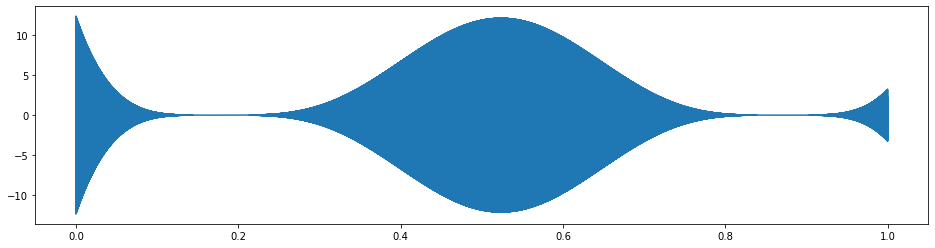

In [26]:
plt.figure(figsize=(16,4))
plt.plot(x.get(), f.get())

In [27]:
fmin = cp.min(f)
fmax = cp.max(f)

In [32]:
h = 0.1 * (fmax - fmin)
bins = cp.ones(10) * fmin + h * cp.arange(10)
hist = cp.array([])
for i in range(10):
    hist = cp.append(hist, (fmin + h * i <= f)*(f < fmin + h * (i + 1)))

In [33]:
%timeit cp.sum(hist.reshape(10,-1), axis=1)

7.89 ms ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [34]:
%timeit np.sum(hist.reshape(10,-1), axis=1)

7.93 ms ± 10.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [29]:
hist = cp.sum(hist.reshape(10,-1), axis=1)

Text(0, 0.5, 'Frequency')

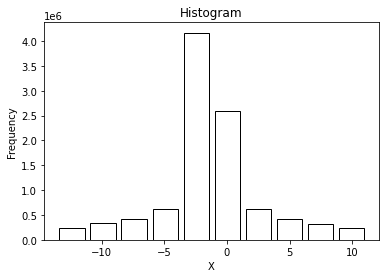

In [23]:
plt.bar(x = bins.get(), height=hist.get(), width=2, color='white', edgecolor='k')
plt.title('Histogram')
plt.xlabel('X')
plt.ylabel('Frequency')

## Task 13. Image blur


<u>By using <i><strong>CuPy</strong></i>:</u>
* Implement the gpu version of the image blur algorithm. What you need to do is calculate convolution some image and some blur filter on every pixel. You should compute convolutions in parallel for every pixel using gpu cores.
* Take any 100x100 image and 

<strong >Example of a blurred image:</strong>
    ![Blur](blur.jpg)

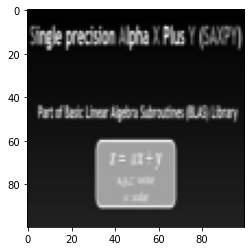

In [9]:
# Before
img = resize(cv2.imread('saxpy.jpg', 0), (100,100))
plt.imshow(img, cmap='gray');

In [10]:
k = 11
kernel = cp.ones((k,k)) / k**2

In [11]:
blur_img = cp_convolve2d(cp.asarray(img), kernel)

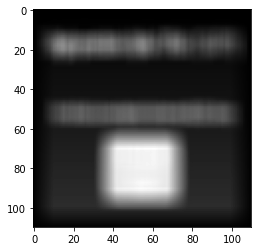

In [12]:
# After
plt.imshow(blur_img.get(), cmap='gray')

In [13]:
# Cupy
%timeit cp_convolve2d(cp.asarray(img), kernel)

247 µs ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
k = 11
kernel = np.ones((k,k)) / k**2

In [15]:
# Scipy (I use it instead of numpy)
%timeit convolve2d(img, kernel)

2.41 ms ± 15 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
